<a href="https://colab.research.google.com/github/tosittig/CASAIS/blob/main/CAS_project5_ts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text to slide generation

In this project you will implement a system which, when provided a text as input, generates the content of a slide deck. The project covers a number of machine learning techniques. We learn how to use sentence embeddings for summarizing texts, how to generate summaries with language models, and how to retrieve or generate images using textual image descriptions.

The structure of the project is as follows.

1. **Slide text.** First, given a text that describes, possibly at length, the desired content of the slide deck, we will obtain a short list of summary sentences. These sentences are the bullet points that appear on the slides. To obtain summary sentences, you will implement two types of techniques, *extractive* and *abstractive* summarization.
  - In **extractive summarization** techniques, the summary sentences are taken directly---extracted---from the text. To achieve this, you will use a language model to obtain sentence embeddings, cluster them into a small number of sentence groupings, and select the most prototypical sentence in each grouping as a summary sentence.
  - In **abstractive summarization** techniques, summary sentences are generated (i.e., they need not, and often are not, present verbatim in the original text). You will use zero-shot and few-shot prompting (*in-context learning*) to have a language model generate summary sentences.


2. **Slide images.** The second part of the project involves obtaining images that match the textual content of the slides. You will use two techniques, *image retrieval* and *text-to-image generation*.
  - For the **image retrieval** solution, you will use a multimodal model to embed both text queries and images (we'll take them from a public database) into a shared semantic space. To select the right image for a slide, you will pick the one that is closest to keywords in the slide text.
  - For the **image generation** approach, you will use a slightly different type of multimodal model with generative capabilities. Given the keywords in the slide text, it generates images from scratch.  

Disclaimers:  
1: You will not generate an actual PowerPoint document (a pptx file), but it should be very easy to create one at this point!  
2: To make this code executable in a simple-to-use python notebook, we had to keep model sizes constrained, which can sometimes result in generated text or images of subpar quality. The exact same techniques used here, however, apply to larger models that run on large GPU clusters and generate higher quality text and images. So please be kind to the smaller models, there is a lot to learn from them!

In [1]:
# @title Install packages.
# @markdown First, make sure you're using a GPU runtime. Then, run this cell. After this cell has run, please restart the session by selecting `Runtime` in the toolbar, then `Restart session`. (You don't need to re-run this cell a second time.)
!pip install accelerate datasets diffusers invisible_watermark
!pip install safetensors sentence_transformers ipyplot==1.1.0
!pip install transformers --upgrade
!pip install diffusers --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6

In [2]:
# @title Import libraries

import numpy as np
import ipyplot
import re
import sklearn
import torch
import transformers
import textwrap
import safetensors

from datasets import load_dataset
from diffusers import AutoPipelineForText2Image, SemanticStableDiffusionPipeline
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from spacy.lang.en import English
from tqdm.notebook import trange, tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, T5ForConditionalGeneration, T5Tokenizer, CLIPProcessor, CLIPModel


        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `base_64` param to `True`.
        


## Convenience function for pretty printing

*You can skip this cell, but you must still execute it.*

In [3]:
def pprint(string, width=120):
  print(textwrap.fill(string, width=width))

## Slide text

Given a text that describes the desired content of the slide deck, you will obtain a short list of summary sentences, or bullet points. To do this, you will use **extractive summarization** and **abstractive summarization** techniques. In extractive summarization, the summary is composed of sentences from the original document. In abstractive summarization, the summary is completely generated and its sentences do not appear necessarily in the original text.
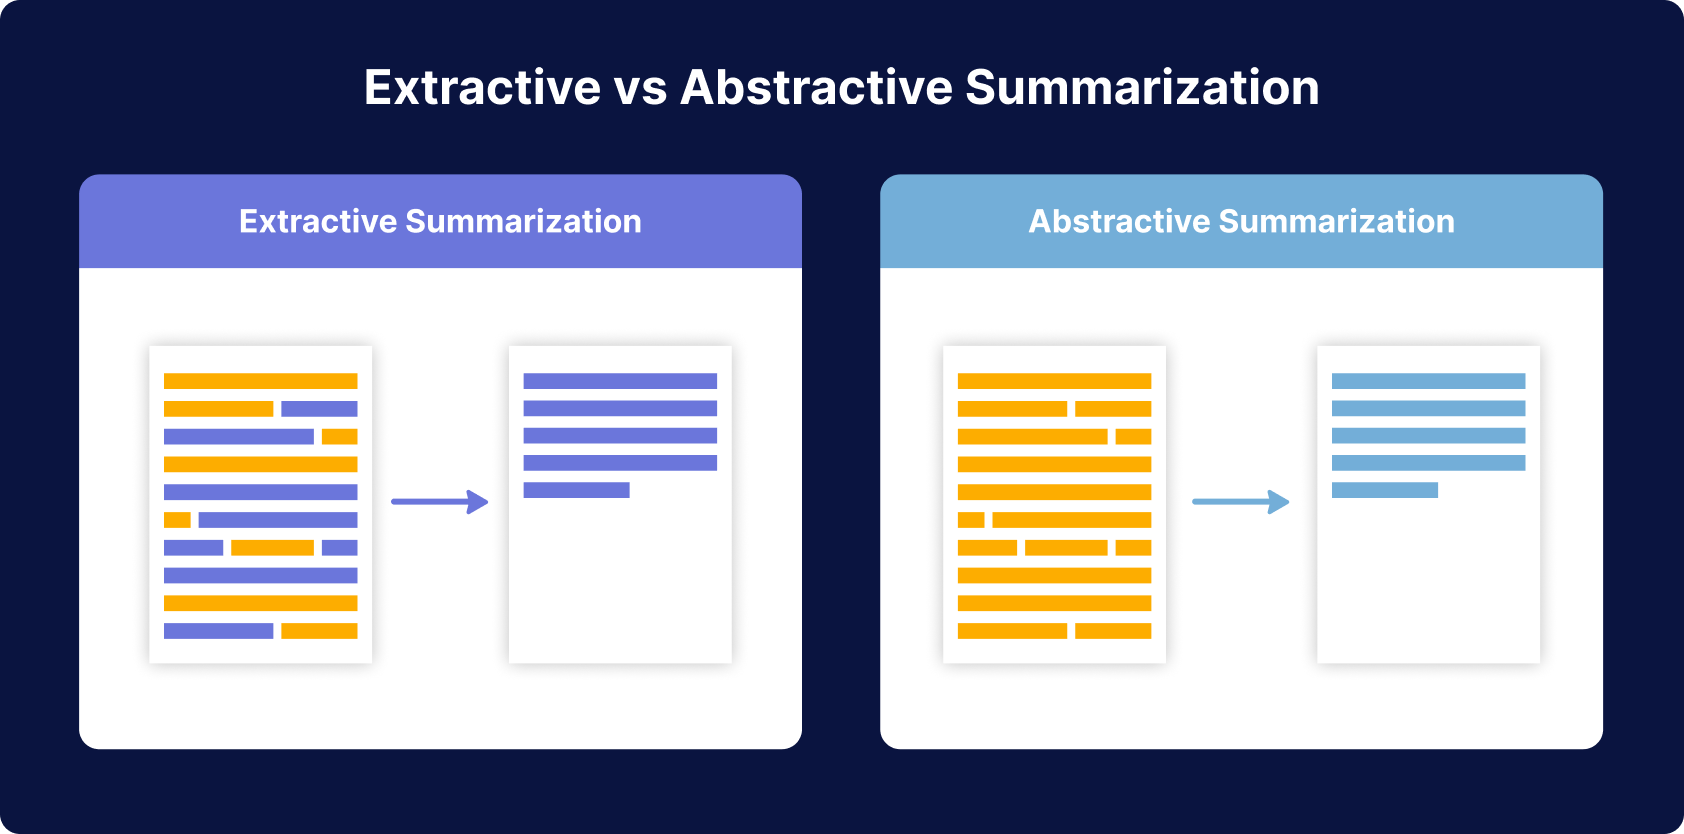

Image from [https://www.abstractivehealth.com/extractive-vs-abstractive-summarization-in-healthcare](https://www.abstractivehealth.com/extractive-vs-abstractive-summarization-in-healthcare).
![Screenshot 2024-03-04 at 18.57.01.png](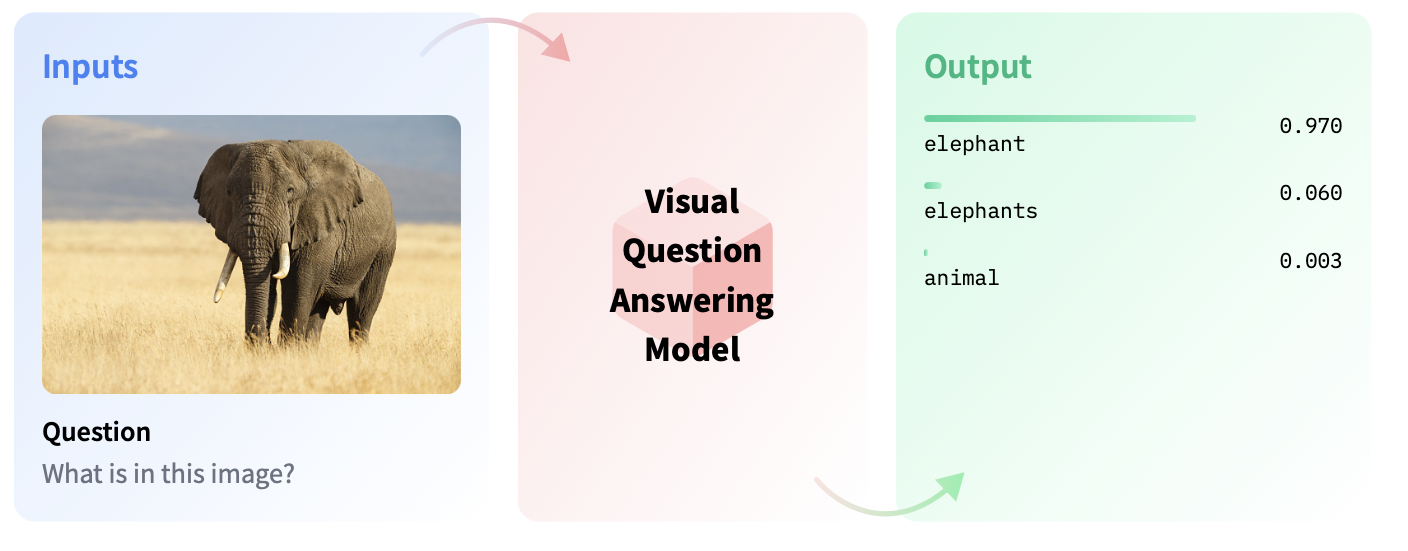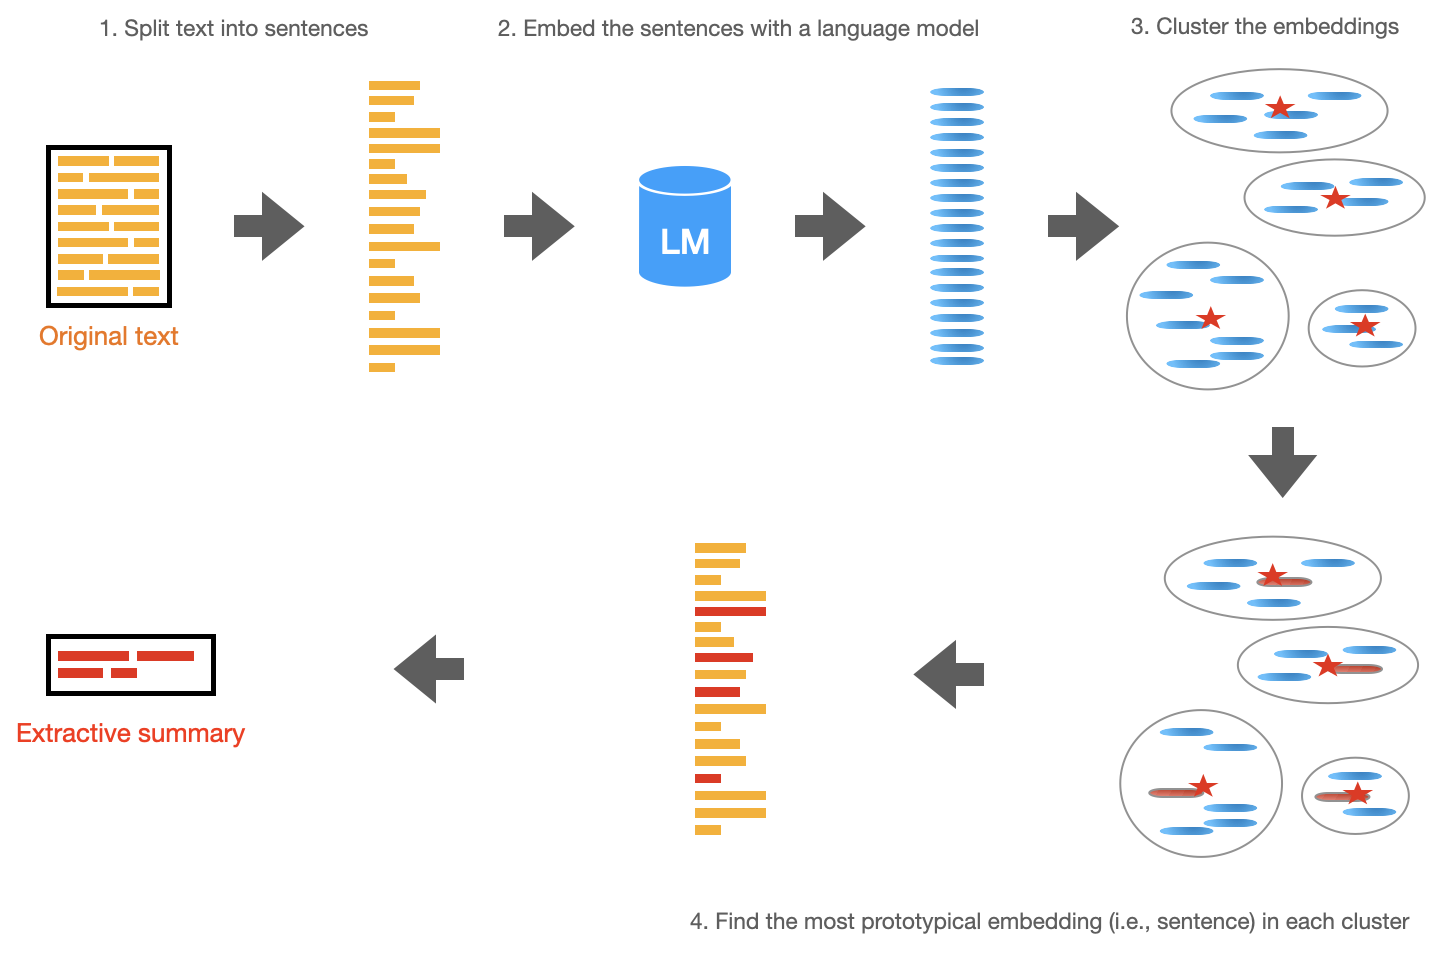)

As an example text, we take a snippet from Anthropic AI's post on their [Core Views on AI Safety](https://www.anthropic.com/news/core-views-on-ai-safety). This is just an example, feel free to pick another text.

In [4]:
original_text = "The three main ingredients leading to predictable improvements in AI performance are training data, computation, and improved algorithms. In the mid-2010s, some of us noticed that larger AI systems were consistently smarter, and so we theorized that the most important ingredient in AI performance might be the total budget for AI training computation. When this was graphed, it became clear that the amount of computation going into the largest models was growing at 10x per year (a doubling time 7 times faster than Moore’s Law). In 2019, several members of what was to become the founding Anthropic team made this idea precise by developing scaling laws for AI, demonstrating that you could make AIs smarter in a predictable way, just by making them larger and training them on more data. Justified in part by these results, this team led the effort to train GPT-3, arguably the first modern “large” language model, with over 173B parameters. Since the discovery of scaling laws, many of us at Anthropic have believed that very rapid AI progress was quite likely. However, back in 2019, it seemed possible that multimodality, logical reasoning, speed of learning, transfer learning across tasks, and long-term memory might be “walls” that would slow or halt the progress of AI. In the years since, several of these “walls”, such as multimodality and logical reasoning, have fallen. Given this, most of us have become increasingly convinced that rapid AI progress will continue rather than stall or plateau. AI systems are now approaching human level performance on a large variety of tasks, and yet training these systems still costs far less than “big science” projects like the Hubble Space Telescope or the Large Hadron Collider – meaning that there’s a lot more room for further growth. People tend to be bad at recognizing and acknowledging exponential growth in its early phases. Although we are seeing rapid progress in AI, there is a tendency to assume that this localized progress must be the exception rather than the rule, and that things will likely return to normal soon. If we are correct, however, the current feeling of rapid AI progress may not end before AI systems have a broad range of capabilities that exceed our own capacities. Furthermore, feedback loops from the use of advanced AI in AI research could make this transition especially swift; we already see the beginnings of this process with the development of code models that make AI researchers more productive, and Constitutional AI reducing our dependence on human feedback. If any of this is correct, then most or all knowledge work may be automatable in the not-too-distant future – this will have profound implications for society, and will also likely change the rate of progress of other technologies as well (an early example of this is how systems like AlphaFold are already speeding up biology today). What form future AI systems will take – whether they will be able to act independently or merely generate information for humans, for example – remains to be determined. Still, it is hard to overstate what a pivotal moment this could be. While we might prefer it if AI progress slowed enough for this transition to be more manageable, taking place over centuries rather than years or decades, we have to prepare for the outcomes we anticipate and not the ones we hope for. Of course this whole picture may be completely wrongheaded. At Anthropic we tend to think it’s more likely than not, but perhaps we’re biased by our work on AI development. Even if that’s the case, we think this picture is plausible enough that it cannot be confidently dismissed. Given the potentially momentous implications, we believe AI companies, policymakers, and civil society institutions should devote very serious effort into research and planning around how to handle transformative AI."
pprint(original_text)

The three main ingredients leading to predictable improvements in AI performance are training data, computation, and
improved algorithms. In the mid-2010s, some of us noticed that larger AI systems were consistently smarter, and so we
theorized that the most important ingredient in AI performance might be the total budget for AI training computation.
When this was graphed, it became clear that the amount of computation going into the largest models was growing at 10x
per year (a doubling time 7 times faster than Moore’s Law). In 2019, several members of what was to become the founding
Anthropic team made this idea precise by developing scaling laws for AI, demonstrating that you could make AIs smarter
in a predictable way, just by making them larger and training them on more data. Justified in part by these results,
this team led the effort to train GPT-3, arguably the first modern “large” language model, with over 173B parameters.
Since the discovery of scaling laws, many of us at Ant

Since this text is relatively short, it can reasonably be presented in a few slides. *We arbitrarily set the target number of slides to **4**.*

In [5]:
n_slides = 4

***Comments:***

*This seems a bit too theoretical. If I want to summarize a text wiith 21 sentences on a ppt-slide containing 4 slides with, let's say 5 bullets each, and the bullets consist of full sentences, then the summarization results in basically eliminating one single sentence from the whole text.*

### Extractive summarization

Let's start with extractive summarization: here, important sections from the original text are identified and reproposed, without being modified in any way. The summary is then a subset of sentences from the original text.

You will follow an approach to extractive summarization that consists of the following steps.

1. Split the text into sentences.
2. Obtain sentence embeddings using a language model.
3. Cluster the sentence embeddings into $k$ groupings.
4. For each cluster, find the most prototypical sentence.



You can think of each of the groupings as one main point the text is making. For each main point, we will pick a representative sentence. This will result in a list of $k$ sentences. Because the slides should probably more than one sentence on average, we will set $k$ to be at least 8 (remember: we aim at producing 4 slides).

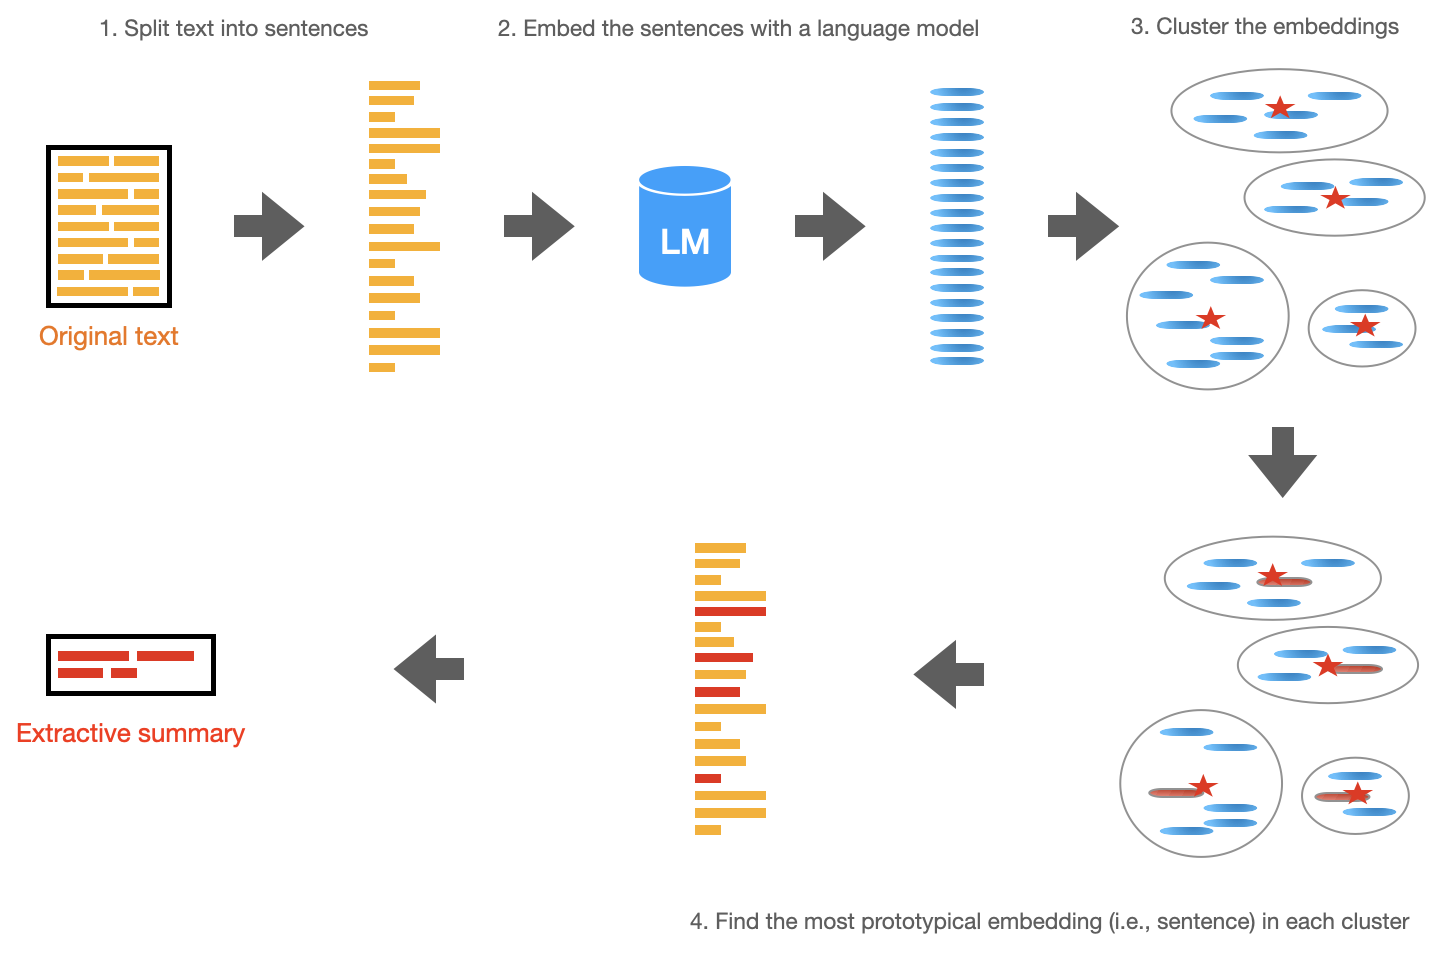



#### Split text into sentences

To split the original text into sentences, we will use SpaCy's sentence segmentation algorithm (you might remember this from Project 4).

*You do not need to understand the code in the cell below, but you must still execute it.*

In [6]:
spacy = English()
spacy.add_pipe("sentencizer")

def split(text):
  """
  Splits a text into sentences using the Spacy library.

  Parameters
  ----------
  text : str
      The text to be split into sentences.

  Returns
  -------
  list
      The list of sentences in the text.
  """
  processed_text = spacy(text)
  processed_sentences = processed_text.sents

  sentences = []
  for sentence in processed_sentences:
    sentences.append(sentence.text)

  return sentences


The code cell above defines a function that splits a text into sentences. Functions are reusable pieces of code that can be applied to different texts. For example, there is a function called `len` which counts the number of characters in a text. You can then use this function as follows:

In [7]:
text1 = "Hello"
print(len(text1))

text2 = "1"
print(len(text2))

text3 = ""
print(len(text3))

5
1
0


The function `split` that we defined above splits a text into sentences and stores them in a list of texts. Here is an example:

In [8]:
text1 = "Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum."
print("\n\n".join(split(text1)))

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua.

Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat.

Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur.

Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.


We can now print each sentence on a separate line as follows:

In [9]:
list1 = split(text1)
for i, sentence in enumerate(list1):
  print(i, sentence)

0 Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua.
1 Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat.
2 Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur.
3 Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.


***Use now this knowledge to separate `original_text` into sentences and print those sentences.***

In [10]:
# Split the text above into sentences
sentence_list = split(original_text)


# Print sentences, one per line
for i, sentence in enumerate(sentence_list):
  print(i, sentence)


0 The three main ingredients leading to predictable improvements in AI performance are training data, computation, and improved algorithms.
1 In the mid-2010s, some of us noticed that larger AI systems were consistently smarter, and so we theorized that the most important ingredient in AI performance might be the total budget for AI training computation.
2 When this was graphed, it became clear that the amount of computation going into the largest models was growing at 10x per year (a doubling time 7 times faster than Moore’s Law).
3 In 2019, several members of what was to become the founding Anthropic team made this idea precise by developing scaling laws for AI, demonstrating that you could make AIs smarter in a predictable way, just by making them larger and training them on more data.
4 Justified in part by these results, this team led the effort to train GPT-3, arguably the first modern “large” language model, with over 173B parameters.
5 Since the discovery of scaling laws, many 

The example text we provided should contain 21 sentences.

#### Obtain sentence embeddings using a language model

To compute sentence embeddings, we will use a Sentence Transformer. This is essentially a pre-trained language model, further trained to optimize the similarity between sentences known to be semantically equivalent (e.g., paraphrases).

***In the cell below, fill in the line of code that computes sentence embeddings using the Sentence Transformer model.***

In [11]:
# Initialize the sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Convert sentences to embeddings
sentence_embeddings = model.encode(sentence_list)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Let's inspect the shape of one of the embeddings and print out its components.

In [12]:
print(f'This {sentence_embeddings[0].shape[0]}-dimensional vector is an abstract representation of the sentence:')
print(sentence_list[0])
print()
print(sentence_embeddings[0])

This 384-dimensional vector is an abstract representation of the sentence:
The three main ingredients leading to predictable improvements in AI performance are training data, computation, and improved algorithms.

[-2.24301810e-04 -5.77038378e-02  2.02206429e-02  1.25701996e-02
  3.41012180e-02  1.46601005e-02 -6.28564805e-02 -4.48250249e-02
 -9.44490265e-03 -2.69601010e-02 -6.46685138e-02  2.95500411e-03
  1.22453608e-02 -2.07881350e-02  3.53161022e-02 -2.46244371e-02
  5.95158637e-02  5.32272719e-02 -8.66301134e-02 -1.38512686e-01
  1.13459425e-02  1.35252427e-03  4.63376455e-02 -1.02875130e-02
  9.63884778e-03  5.22210859e-02 -2.22204011e-02 -6.91944137e-02
 -8.48357007e-03 -2.04993729e-02  6.76774159e-02 -5.24821393e-02
  1.03726916e-01 -5.60408123e-02 -1.14863105e-01  1.61207374e-02
 -4.89096902e-02  3.60825174e-02  6.30539730e-02  3.77318040e-02
 -1.08489059e-02 -1.65066272e-02  3.03170402e-02 -1.62816816e-03
  7.24021494e-02  8.12096298e-02 -2.62045860e-03 -8.60367045e-02
 -2.51

#### Cluster the sentence embeddings into k groupings

To cluster the embeddings you will use a standard clustering algorithm called $k$-Means. Simply put, $k$-Means measures the distance between all pairs of embeddings and forms clusters so as to minimize the distances between data points within each cluster. In other words, it finds the arrangement of data points such that the data points in each cluster are as close as possible to each other. The main parameter of $k$-Means is, unsurprisingly, $k$, the desired number of clusters.

***Write code to initialize, fit, and predict with $k$-Means.***

***Reflexion:***

*The code below will cluster the sentence embeddings using k-Means with the specified number of clusters (k) and assign each sentence to its corresponding cluster.
As I want to have 4 ppt-slides with on average 4 bullets, the number of clusters would be 16. However, given that the text only contains 21 sentences, and we will select a full sentence to summarize the text, I will limit the nuber of clusters to 4. This would potentially be used as the title for the slide*

In [13]:
# Set the number of clusters appropriately. Remember: the slides should contain
# more than one sentence on average, and we aim at obtaining 4 slides.

k = 4

# Initialize KMeans
kmeans = KMeans(n_clusters=k)

# Cluster the sentence embeddings and extract the cluster id of each embedding
cluster_ids = kmeans.fit_predict(sentence_embeddings)


# Assign each sentence (text and embedding) to the respective cluster
clustered_sentences = {i: [] for i in range(k)}
clustered_embeddings = {i: [] for i in range(k)}
for sentence, embedding, cluster_id in zip(sentence_list, sentence_embeddings, cluster_ids):
  clustered_sentences[cluster_id].append(sentence)
  clustered_embeddings[cluster_id].append(embedding)

clustered_sentences

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


{0: ['When this was graphed, it became clear that the amount of computation going into the largest models was growing at 10x per year (a doubling time 7 times faster than Moore’s Law).',
  'Justified in part by these results, this team led the effort to train GPT-3, arguably the first modern “large” language model, with over 173B parameters.',
  'People tend to be bad at recognizing and acknowledging exponential growth in its early phases.'],
 1: ['The three main ingredients leading to predictable improvements in AI performance are training data, computation, and improved algorithms.',
  'In the mid-2010s, some of us noticed that larger AI systems were consistently smarter, and so we theorized that the most important ingredient in AI performance might be the total budget for AI training computation.',
  'In 2019, several members of what was to become the founding Anthropic team made this idea precise by developing scaling laws for AI, demonstrating that you could make AIs smarter in a 

Some clusters contain only once sentence, some others contain more than one. For the latter ones, we will now find the most prototypical sentence and discard the others.

#### Find the most prototypical sentence in each cluster

To find the most prototypical sentence, we will exploit the notion of *cluster centroid*, this is the vector that's "at the center" of a cluster. More precisely, it is the average of all vectors in a cluster, and is thus representative of the cluster's semantics. By measuring the distance between the centroid and all the embeddings in a given cluster, we can find out which embedding is closest to centroid, and thus most prototypical.

**Distance metric**. As a distance metric, we will use the Euclidean distance (or L2-norm) as this is the metric used in the $k$-Means algorithm: $$d_{Euclidean}(u,v) = || u - v ||_2$$

In [14]:
def euclidean_distance(u, v):
  return np.linalg.norm(u - v)


First, let's define a function that, given a cluster centroid and a set of cluster embeddings, returns the index of the embedding closest to the centroid, the prototypical one.

In the code below, we precompute the Euclidean distances between each sentence embedding and the centroid. ***Write code to identify the most prototypical vector in the cluster, i.e., the one with the smallest distance from the centroid.***

In [19]:
def find_prototypical(centroid, vectors):
  """
  Finds the most prototypical vector in a cluster.

  Parameters
  ----------
  centroid : list or numpy.ndarray
      The centroid of the cluster. This should be a 1D vector.
  vectors : list of list or numpy.ndarray
      The vectors in the cluster. This should be a 2D matrix or a list of 1D vectors.

  Returns
  -------
  int
      The index of the most prototypical vector in the cluster.
  """

  # First, we compute all the distances between all vectors (embeddings)
  # and the cluster centroid.
  # --------------------------------------------------------------------
  distances = []

  # for each vector...
  for vector in vectors:

    # compute distance between centroid and this vector
    d = euclidean_distance(centroid, vector)

    # and store it
    distances.append(d)
  # --------------------------------------------------------------------


  # Then, find the index of the vector that is closest to the centroid
  # --------------------------------------------------------------------

    prototypical_index = np.argmin(distances)


  # --------------------------------------------------------------------

  return prototypical_index


***Reflexion:***

*The function "find_prototypical" calculates the distances between the centroid embedding and all the embeddings in the cluster and stores them in a list. Then, it finds the index of the minimum distance in the list, which corresponds to the most prototypical embedding. Finally, it returns this index.*

Now, let's find the prototypical sentence in each cluster. You are not required to go through the code in the cell below, but please make sure to run it. *(If you do want to understand how we do this, each line of code comes with a little explanation.)*

In [20]:
# Obtain cluster centroids from k-Means
cluter_centroids = kmeans.cluster_centers_

# This dictionary stores the indices of the prototypical sentences
prototypical_sentence_indices = {}

# Loop through clusters
for cluster_id in range(k):

  # Get cluster centroid
  cluster_centroid = cluter_centroids[cluster_id]

  # Get cluster embeddings
  cluster_embeddings = clustered_embeddings[cluster_id]

  # Find the prototypical embedding in this cluster
  prototypical_index = find_prototypical(cluster_centroid, cluster_embeddings)

  # And store its index
  prototypical_sentence_indices[cluster_id] = prototypical_index


# Now we arrange the sentences accordingly
prototypical_sentences = []
for cluster_id in range(k):

  # Get the sentences in this cluster
  cluster_sentences = clustered_sentences[cluster_id]

  # Get the index of the prototypical sentence
  prototypical_sentence_index = prototypical_sentence_indices[cluster_id]

  # Store the prototypical sentence
  prototypical_sentences.append(
    cluster_sentences[prototypical_sentence_index]
  )


# We now have the k summary sentences that we were looking for...
# but they are shuffled as a result of the clustering
original_indices = []
for sent in prototypical_sentences:
  original_indices.append(sentence_list.index(sent))

# We re-organize them based on their original order in the document
new_indices = np.argsort(original_indices)
prototypical_sentences = [prototypical_sentences[i] for i in new_indices]

extractive_summary_sentences = prototypical_sentences


In [21]:
# These are the extracted summary sentences
print('Summary sentences:\n')
for i, sent in enumerate(extractive_summary_sentences, start=1):
  print(i, sent)

Summary sentences:

1 When this was graphed, it became clear that the amount of computation going into the largest models was growing at 10x per year (a doubling time 7 times faster than Moore’s Law).
2 Since the discovery of scaling laws, many of us at Anthropic have believed that very rapid AI progress was quite likely.
3 However, back in 2019, it seemed possible that multimodality, logical reasoning, speed of learning, transfer learning across tasks, and long-term memory might be “walls” that would slow or halt the progress of AI.
4 Even if that’s the case, we think this picture is plausible enough that it cannot be confidently dismissed.


Because these sentences are simply extracted and not modified, some of them might not all look like a bullet point you'd want to have on a slide. For example, they might contain references to sentences that have been discarded. In the next section, we will use abstractive summarization to try to address this problem. The generated sentences might be slightly less faithful to the original text but they will hopefully make for a more coherent set of bullet points.

### Abstractive summarization

We now move to abstractive summarization: unlike extractive approaches, which simply identify important sentences and "generate" them without any modification, abstractive summarization techniques reformulate prominent concepts or ideas in the original text, possibly including words or sentences that do not exist in the original text.

You will implement an end-to-end approach to abstractive summarization that relies on the ability of a large language model to generate summaries when instructed to do via natural language. You will provide instructions (or *prompts*) to the model in two ways.
- **Zero-shot prompting**: the model is simply provided with the original text and a task instruction such as `"summarise the content of this text"`. Zero-shot here indicates that the model is not provided any examples ("shots") of how the task should be performed.
- **Few-shot prompting**: the model is provided with the original text, a task instruction, as well as a few examples of how that task should be executed (in this case, a few text-summary pairs). This approach is typically also referred to as *in-context learning* to highlight that the model is learning to perform a task solely by conditioning on examples (examples are provided in its context window), without any parameter update (unlike, e.g., in *fine-tuning*).

We start by constructing a `TextGenerator` class which will come in handy throughout this section. This is a re-usable piece of code which initializes a text generation pipeline (as seen in Project 4) and generates text conditioned on a prompt.

*Please run the following cell.*

In [22]:
class TextGenerator:
  """
  A class used to generate text using a specified model.
  """

  # Initialize model and tokenizer
  def __init__(
    self,
    model_name="google/flan-t5-xl",
    device=None
  ):
    self.device = device
    if self.device is None:
      self.device = "cuda" if torch.cuda.is_available() else "cpu"

    self.model = T5ForConditionalGeneration.from_pretrained(model_name).to(self.device)
    self.tokenizer = T5Tokenizer.from_pretrained(model_name)


  # Generate
  def generate(self, input, max_new_tokens=500):
    assert type(input) == str
    input_encoded = self.tokenizer(input, return_tensors="pt").to(self.device)

    output = self.model.generate(
      **input_encoded,
      max_new_tokens=max_new_tokens,
      do_sample=True,
      top_p=0.9,
      temperature=0.5
    )


    # Transform token ids into actual words
    generation = self.tokenizer.decode(output[0], skip_special_tokens=True)

    return generation

As a generator, you can use Google's[`Flan-T5 XL`](https://huggingface.co/google/flan-t5-xl). This is a relatively large language model first pre-trained on unstructured language data and then fine-tuned on a mix of chat and instruction datasets. If you have trouble running this model on Colab, you can try the smaller variant; simply substitute the line in the cell below with`generator = TextGenerator("google/flan-t5-large")`

This is how we initialise and use a text generator.

In [23]:
generator = TextGenerator("google/flan-t5-xl")

config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/53.0k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.45G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Let's test the generator now. Remember: this is a general-purpose model trained to follow instructions and interact in a conversational way.

In [24]:
generator.generate(
    input="Answer the following question by reasoning step-by-step. \
    Q: Which statement is sarcastic? Options: \
    (A) Wow thats crazy, I've never had a takeout meal that used hardwood containers before! \
    (B) Wow thats crazy, I've never had a takeout meal that used plastic containers before! \
    A: Let's think step by step."
)

'Takeout meals are usually packaged in plastic containers. So, the answer is (B).'

***Comments***

*On the example above, this model seems to be working quite fine!*

#### Zero-shot

You are now going to use the language model as a summarizer in a zero-shot setup. You are simply going to provide the model with the original text followed by a task instruction.


In [26]:
zero_shot_prompt_1 = '\nSummarize.\n'  # '\n' is simply a new line symbol

zero_shot_summary_1 = generator.generate(original_text + zero_shot_prompt_1)

print("\nSummary:")
pprint(zero_shot_summary_1)


Summary:
Anthropic has developed scaling laws for AI, which have enabled us to make AIs smarter in a predictable way. We have
become increasingly convinced that rapid AI progress will continue rather than stall or plateau.


The instruction is quite generic, so the model simply produces an abstractive summary. Because we want a set of summary sentences that can be used in slides, rather than a summary paragraph, we can specifiy this in the instruction.

In [25]:
zero_shot_prompt_2 = '\nSummarize in 8 bullets. \n 1.'  # '1.' gives the model a hint for the format its output should take

zero_shot_summary_2 = generator.generate(original_text + zero_shot_prompt_2)

print("\nSummary:")
pprint(zero_shot_summary_2)

Token indices sequence length is longer than the specified maximum sequence length for this model (811 > 512). Running this sequence through the model will result in indexing errors



Summary:
1. The Anthropic team has been observing that AI progress is currently rapid. 2. We believe that rapid AI progress will
continue rather than stall or plateau. 3. We believe that most or all knowledge work may be automatable in the not-too-
distant future. 4. We believe that future AI systems will be able to act independently. 5. We believe that future AI
systems will be able to act independently.


***Reflexions***

*The warning related to the token indices sequence length may relate to the length of the sentences of the input text. I assume, that some of the sentences exceed the maximum sequence length supported by the model. This could be solved by preprocessing the text, cutting it into smaller chunks of text.*

***Try at least 3 more ways to formulate the instruction, inspect the output summary, and report what you find.***

In [45]:
zero_shot_prompt_3 = '\n Summarize 4 key findings numbered \n 1. \n 2. \n 3. \n 4. Be short'
zero_shot_summary_3 = generator.generate(original_text + zero_shot_prompt_3)

print("\nSummary:")
pprint(zero_shot_summary_3)


Summary:
1. AI is getting smarter. 2. Training AIs is becoming cheaper. 3. Rapid AI progress is likely to continue. 4. We have to
prepare for the outcomes we anticipate and not the ones we hope for.


***Report Trial 1***

*My intentions were to clarify the prompt in a way to make sure I would really get the number of items I want to receive from the model (n=4) and try to convice the model to be as brief as possible, so I could use the outcome as title for the ppt-Slide.*

*Findings*


*   *giving all 4 numbers in the prompt helped a lot*
*   *also the instruction "be short" had quite a massive impact*
*   *The content seems to be a bit overly simplified*





In [50]:
zero_shot_prompt_4 = '\n Summarize into four slides, each with a title and 3 to 4 bullet points of key arguments: \n Title 1 \n - Key argument 1 \n - Key argument 2 \n - Key argument 3'

zero_shot_summary_4 = generator.generate(original_text + zero_shot_prompt_4)

print("\nSummary:")
pprint(zero_shot_summary_4)


Summary:
Title 1: Rapid AI Progress - Key argument 1: Rapid AI progress may not end before AI systems have a broad range of
capabilities that exceed our own capacities


***Report Trial 2***

*My intentions were to describe my intentions in natural language, indicating clearly what was the intended use of the ouptput, including a slides tiitle and bullets.*

Findings

*   *That was clearly to complicated for the model to understand*
*   *I assume there must be something like a maximum lenghth for the prompt*



In [69]:
zero_shot_prompt_5 = '\n Provide 4 key findings numbered \n 1. \n 2. \n 3. \n 4. Do it step by step. List arguments.'
zero_shot_summary_5 = generator.generate(original_text + zero_shot_prompt_5)

print("\nSummary:")
pprint(zero_shot_summary_5)


Summary:
1. AI systems are now approaching human level performance on a large variety of tasks, and yet training these systems
still costs far less than “big science” projects like the Hubble Space Telescope or the Large Hadron Collider – meaning
that there’s a lot more room for further growth. 2. People tend to be bad at recognizing and acknowledging exponential
growth in its early phases. 3. If any of this is correct, then most or all knowledge work may be automatable in the not-
too-distant future – this will have profound implications for society, and will also likely change the rate of progress
of other technologies as well (an early example of this is how systems like AlphaFold are already speeding up biology
today). 4. Given the potentially momentous implications, we believe AI companies, policymakers, and civil society
institutions should devote very serious effort into research and planning around how to handle transformative AI.


***Report Trial 3***

*My intentions were to combine what worked best in Trial 1, providing instructions in very short, clear sentences, and giving not just an example of how the numbered list of items woudl look like, but all numbers 1 to 4.*

*Findings:*

*   *I still got my four numbered sentences as intended*
*   *The model added some more arguments to each slide, which could be formatted as bullets in a later step*

What are good ways of instructing the model? Were you able to detect any pattern for what works well? Do longer, more specific instructions work better? ***Please discuss this in a short text.***

***My answer...***

*Based on my trials, the following pattern worked most successfully for prompting the Flan_T5 XL language model in a zero-shot approach:*

*   *Provide instructions in very clear short sentences*
*   *Splitting up instructions into several sentences provided better results then combining them into one sentence*
*   *Instruction sentences should not be interrelated (i.e. each instruction could be read on a stand-alone basis and interpreted independently of their order.*
*   *Try instructions such as "be short" or "step by step", as they had a massive, but somewwhat impredictable impfluence on the results*

*Unsuccessful strategies:*

*   *Lengthy Text that was exceeding a certain number of lines/instructions seemed to be ignored*
*   *Complicated sentence structures were misunderstood, even if very clear in natural language*

#### Few-shot

Hopefully you are impressed by what the model can do without any task examples. Although this is not a large model by today's standards, and its performance is not close to that of commercial products, two years ago all of this would have been unthinkable!

However, we can still improve the model output by providing it with examples of how we want to perform the task. We provide one such example here, but we strongly encourage you to devise your own example (1) so that you can test the model in a 2-shot setup and, perhaps more importantly, (2) so you think through the reasoning process the language model has to perform to solve the task.



In [71]:
print('ORIGINAL TEXT')
few_shot_prompt_1_source_text = "We're introducing custom instructions so that you can tailor ChatGPT to better meet your needs. This feature will be available in beta starting with the Plus plan today, expanding to all users in the coming weeks. Custom instructions allow you to add preferences or requirements that you'd like ChatGPT to consider when generating its responses. We've heard your feedback about the friction of starting each ChatGPT conversation afresh. Through our conversations with users across 22 countries, we've deepened our understanding of the essential role steerability plays in enabling our models to effectively reflect the diverse contexts and unique needs of each person. ChatGPT will consider your custom instructions for every conversation going forward. The model will consider the instructions every time it responds, so you won’t have to repeat your preferences or information in every conversation. For example, a teacher crafting a lesson plan no longer has to repeat that they're teaching 3rd grade science. A developer preferring efficient code in a language that’s not Python – they can say it once, and it's understood. Grocery shopping for a big family becomes easier, with the model accounting for 6 servings in the grocery list."
pprint(few_shot_prompt_1_source_text)
print()
print('TASK INSTRUCTION')
few_shot_prompt_instruction = "Summarize in 8 bullet points."
pprint(few_shot_prompt_instruction)
print()
print('OUTPUT EXAMPLE')
few_shot_prompt_1_summary_example = "1. Custom instructions will be available in beta starting today. 2. Custom instructions allow you to steer ChatGPT by specifying your own preferences or requirements. 3. Custom instructions make ChatGPT much more aligned to each user's unique needs. 4. This leads to superior outputs than starting a conversation always afresh. 5. You won't have to repeat your preferences or information in every conversation. 6. The model will consider the instructions every time it responds. 7. For example, if you are a 3rd grade teacher crafting lesson plans, you won't have to repeat this information for each lesson. 8. Or, if you are a programmer and prefer another language to Python, you won't have to specify that for each code snippet."
pprint(few_shot_prompt_1_summary_example)
print()

ORIGINAL TEXT
We're introducing custom instructions so that you can tailor ChatGPT to better meet your needs. This feature will be
available in beta starting with the Plus plan today, expanding to all users in the coming weeks. Custom instructions
allow you to add preferences or requirements that you'd like ChatGPT to consider when generating its responses. We've
heard your feedback about the friction of starting each ChatGPT conversation afresh. Through our conversations with
users across 22 countries, we've deepened our understanding of the essential role steerability plays in enabling our
models to effectively reflect the diverse contexts and unique needs of each person. ChatGPT will consider your custom
instructions for every conversation going forward. The model will consider the instructions every time it responds, so
you won’t have to repeat your preferences or information in every conversation. For example, a teacher crafting a lesson
plan no longer has to repeat that they're t

Let's see if the model fares better in an in-context learning, 1-shot scenario.


In [72]:
one_shot_summary = generator.generate(
  few_shot_prompt_1_source_text + "\n" +
  few_shot_prompt_instruction + "\n" +
  few_shot_prompt_1_summary_example + "\n" +
  original_text + "\n" +
  few_shot_prompt_instruction + "\n"
)

pprint(one_shot_summary)

1. We have seen a very rapid AI progress in recent years. 2. We think this progress will continue rather than stall or
plateau. 3. We have to prepare for the outcomes we anticipate and not the ones we hope for.


***Devise your own example consisting of a source text and a summary.*** Feel free to also change the instruction text.

In [158]:
print('ORIGINAL TEXT')
few_shot_prompt_2_source_text = "Herbert Kroemer, a German-born American physicist who was awarded the Nobel Prize for his part in discoveries that paved the way for the development of many trappings of modern life, including high-speed internet communication, mobile phones and bar-code readers, died on March 8. He was 95. The death was announced by the University of California, Santa Barbara, where he was an emeritus professor. No further details were provided in a statement. Dr. Kroemer’s most important contributions were in the development of so-called heterostructures. They vastly enhance the speed, and therefore the power, of transistors and other types of semiconductors that are the building blocks of all electronic equipment. The Nobel Committee’s recognition of Dr. Kroemer’s work was unusual, since his breakthrough was in applied science rather than in pure research, which is typically where the biggest advances in the understanding of physics occur. But by the time he received a share, with two other scientists, of the Nobel Prize in Physics in 2000, the impact of his work was so enormous, it could not be denied."
pprint(few_shot_prompt_2_source_text)
print()

# Feel free to edit this.
print('TASK INSTRUCTION')
few_shot_prompt_instruction = '\n Provide 8 key findings \n 1. \n 2. \n 3. \n 4. \n 5. \n 6. \n 7. \n 8. Do it step-by-step. Deliver arguments.'
pprint(few_shot_prompt_instruction)
print()

print('OUTPUT EXAMPLE')
few_shot_prompt_2_summary_example = "1.	Herbert Kroemer, a German-born American physicist died on March 8. 2. He was 95. 3. The University of California, Santa Barbara, where he was a professor, announced his death. 4. Kroemer's key contributions were in developing heterostructures 5. His findings boosted the speed and efficiency of semiconductors. 6. This laid foundations for modern technologies like high-speed internet and mobile phones. 7. Despite being in applied science he received the Nobel Prize in Physics in 2000. 8. Kroemer's work left an undeniable impact on modern electronics."
pprint(few_shot_prompt_2_summary_example)
print()


ORIGINAL TEXT
Herbert Kroemer, a German-born American physicist who was awarded the Nobel Prize for his part in discoveries that paved
the way for the development of many trappings of modern life, including high-speed internet communication, mobile phones
and bar-code readers, died on March 8. He was 95. The death was announced by the University of California, Santa
Barbara, where he was an emeritus professor. No further details were provided in a statement. Dr. Kroemer’s most
important contributions were in the development of so-called heterostructures. They vastly enhance the speed, and
therefore the power, of transistors and other types of semiconductors that are the building blocks of all electronic
equipment. The Nobel Committee’s recognition of Dr. Kroemer’s work was unusual, since his breakthrough was in applied
science rather than in pure research, which is typically where the biggest advances in the understanding of physics
occur. But by the time he received a share, with two 

Now let's test the two-shot summarizer.

In [159]:
two_shot_summary = generator.generate(
  few_shot_prompt_1_source_text + "\n" +
  few_shot_prompt_instruction + "\n" +
  few_shot_prompt_1_summary_example + "\n" +
  few_shot_prompt_2_source_text + "\n" +
  few_shot_prompt_instruction + "\n" +
  few_shot_prompt_2_summary_example + "\n" +
  original_text + "\n" +
  few_shot_prompt_instruction + "\n"
)

pprint(two_shot_summary)

1. The three main ingredients leading to predictable improvements in AI performance are training data, computation, and
improved algorithms. 2. In the mid-2010s, some of us noticed that larger AI systems were consistently smarter, and so we
theorized that the most important ingredient in AI performance might be the total budget for AI training computation. 3.
In 2019, several members of what was to become the founding Anthropic team made this idea precise by developing scaling
laws for AI, demonstrating that you could make AIs smarter in a predictable way, just by making them larger and training
them on more data. 4. In the years since, several of these “walls”, such as multimodality and logical reasoning, have
fallen. 5. People tend to be bad at recognizing and acknowledging exponential growth in its early phases. 6. If we are
correct, however, the current feeling of rapid AI progress may not end before AI systems have a broad range of
capabilities that exceed our own capacities. 7. I

The code below reformats the generated sentences. You don't need to go through it, but *please make sure to run the cell.*

In [160]:
def clean_sentence(sentence):
    """
    This function removes any newline characters followed by any number of spaces and digits from a sentence.
    It also removes leading and trailing spaces from the sentence.

    Args:
        sentence (str): The sentence to be cleaned.

    Returns:
        str: The cleaned sentence.
    """
    return re.sub(r"\n\s\d*.*", "", sentence).strip()

def get_summary_sentences(string):
    """
    This function splits a string into sentences, cleans each sentence, and returns a list of cleaned sentences
    that have more than 3 characters.

    Args:
        string (str): The string to be split into sentences.

    Returns:
        list: A list of cleaned sentences with more than 3 characters.
    """
    sentences = split(string)
    return [clean_sentence(sent) for sent in sentences if len(sent) > 3]


Let's inspect the cleaned-up summary sentences obtained with the three methods.

In [161]:
zero_shot_summary_sentences = get_summary_sentences(zero_shot_summary_2)
one_shot_summary_sentences = get_summary_sentences(one_shot_summary)
two_shot_summary_sentences = get_summary_sentences(two_shot_summary)

print('Zero-shot summary sentences')
for s in zero_shot_summary_sentences:
  print(s)
print()

print('One-shot summary sentences')
for s in one_shot_summary_sentences:
  print(s)
print()

print('Two-shot summary sentences')
for s in two_shot_summary_sentences:
  print(s)
print()

Zero-shot summary sentences
The Anthropic team has been observing that AI progress is currently rapid.
We believe that rapid AI progress will continue rather than stall or plateau.
We believe that most or all knowledge work may be automatable in the not-too-distant future.
We believe that future AI systems will be able to act independently.
We believe that future AI systems will be able to act independently.

One-shot summary sentences
We have seen a very rapid AI progress in recent years.
We think this progress will continue rather than stall or plateau.
We have to prepare for the outcomes we anticipate and not the ones we hope for.

Two-shot summary sentences
The three main ingredients leading to predictable improvements in AI performance are training data, computation, and improved algorithms.
In the mid-2010s, some of us noticed that larger AI systems were consistently smarter, and so we theorized that the most important ingredient in AI performance might be the total budget for AI

Does the model benefit from more examples? What do good examples look like? If you tried updating the instruction text, were you able to detect any pattern for what works well?
***Please discuss this in a short text.***

***Your answer...***

*The additional examples brought in by one-shoot learning and two-shoot learning clearly imrpoved the models performance in relation to the form and presentation of its output. Specifically I noted the following improvements:*
*   *Summary texst were less monotonous and repetitive*
*   *Apparently, the model got a better understanding of the task of summarization*
*   *Also, the initial problems, like delivering less than the expected 8 bullets, disappeared*

*Regarding the instruction text, the formulations continued to have a decisive impact on the models behaviour and the level of details and accuracy deleivered. I have the impression, that the patterns that were most successfull for the zero-shot setup were still performing best, also in the two-shot summarizer:*

*   *Use a very clear, concise language*
*   *Provide instructions in very clear short sentences rather than combine several requirements into one sentence*
*  *Include all 8 numbers for the 8 sentences epected to be provided in the results*

*   *Provide contextual cues such as "do it step by step" to prevent the model from repeating the same finding twice or "discuss arguments" to encourage it to provide some reasonsing for the statements given*

### Sort summary sentences into slides

Now that we have a set of summary sentences—whether from the extractive or the abstractive summarizer—we want to organize them into slides. For this purpose, we will use clustering again.

Pick the set of sentences you prefer out of`zero_shot_summary_sentences`, `one_shot_summary_sentences`, and `two_shot_summary_sentences`.
**Set the `final_summary_sentences` accordingly** (e.g., `final_summary_sentences = zero_shot_summary_sentences`).

If you're not happy with the automatically generated summary sentences and/or you didn't manage to obtain at least `n_slides` (4), please manually design a few summary sentences.

In [162]:
final_summary_sentences = two_shot_summary_sentences


***Write code to cluster summary sentences into 4 groupings.***
1. Initialise a `SentenceTransformer` model
2. Embed the `final_summary_sentences` with the model
3. Use `KMeans` to cluster the sentence embeddings
4. Assign each sentence to the respective cluster (we have implemented this, but feel free to edit our code so long as the final output matches the format given below.

In [163]:
# the final output should be a list of lists, for example:
#[
#  [summary_sentence_1_slide_1, summary_sentence_2_slide_1],
#  [summary_sentence_1_slide_2, summary_sentence_2_slide_2, summary_sentence_3_slide_2],
#  [summary_sentence_1_slide_3, summary_sentence_2_slide_3],
#  [summary_sentence_1_slide_4]
#]


# Initialize the sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Convert sentences to embeddings
sentence_embeddings = model.encode(final_summary_sentences)

# Use k-Means clustering (set k appropriately)
kmeans = KMeans(n_clusters=k, n_init="auto")
final_cluster_ids = kmeans.fit_predict(sentence_embeddings)

# Assign each sentence (text and embedding) to the respective cluster
clustered_sentences = {i: [] for i in range(k)}
for sentence, cluster_id in zip(final_summary_sentences, final_cluster_ids):
  clustered_sentences[cluster_id].append(sentence)


Let's take a look at the text of the slides.

In [164]:
slides_text = [sentences for _, sentences in clustered_sentences.items()]

In [165]:
for i, slide_text in enumerate(slides_text, start=1):
  print(f"Slide {i}")
  for summary_sentence in slide_text:
    print(f"- {summary_sentence}")
  print()

Slide 1
- If we are correct, however, the current feeling of rapid AI progress may not end before AI systems have a broad range of capabilities that exceed our own capacities.
- If any of this is correct, then most or all knowledge work may be automatable in the not-too-distant future – this will have profound implications for society, and will also likely change the rate of progress of other technologies as well (an early example of this is how systems like AlphaFold are already speeding up biology today).
- Given the potentially momentous implications, we believe AI companies, policymakers, and civil society institutions should devote very serious effort into research and planning around how to handle transformative AI.

Slide 2
- People tend to be bad at recognizing and acknowledging exponential growth in its early phases.

Slide 3
- The three main ingredients leading to predictable improvements in AI performance are training data, computation, and improved algorithms.
- In the mid-

## Slide images

Now that the slide text is ready, we can select or generate images that go with it. We will aim at *one image per slide*. To do this, you will experiment with two machine learning techniques: image retrieval and image generation.

- In **image retrieval**, given a textual image description and a database of images, the goal is to find the image closest to the textual description.
- In **image generation**, given a textual image description, and image that fits that description is generated.

For both approaches, you will need image descriptions—either as queries for retrieval or as input for image generation. So the first subsection of this second part of the project concerns obtaining image descriptions.

In theory, we could use the slide text directly, and retrieve or generate images based on that. However, most current vision models are trained on image descriptions in a specific format: typically, these are short sentences that faithfully describe the content of the image. In this first subsection of Part 2, you will use keyphrase extraction technique to extract short descriptions from slide text.

### Obtaining image descriptions

To obtain image descriptions—one for each slide—we will use the multi-purpose generator from above. We will provide the generator with the summary sentences obtained in the previous section, and ask it to extract keyphrases from them.

There are many approaches to keyphrase extraction, some much less sophisticated than using a text generator. But for the purpose of this project, we will use the generator in a zero-shot and few-shot setup.

**Zero-shot**. Design an instruction for this task and generate a keyphrase for each subset of the summary sentences. In the example below, we pick `two_shot_summary_sentences`, but feel free to use the set of summary sentences that you deem of highest quality out of `extractive_summary_sentences`, `zero_shot_summary_sentences`, `one_shot_summary_sentences` and `two_shot_summary_sentences` (these are the names of the Python variables that contain summary sentences, as obtained in the cells above).

***Design a zero-shot instruction. Write the corresponding code in the cells below.***

In [181]:
zero_shot_instruction = '\n Provide a headline that summarizes this text. Be short and concise. \n'

In [182]:
keyphrases = []
for sentences in slides_text:

  # This line simply concatenates the summary sentences by inserting a whitespace between them
  input = " ".join(sentences)

  # Generate given summary sentences and instruction
  generation = generator.generate(input + "\n" + zero_shot_instruction)

  # Store generated key phrase
  keyphrases.append(generation)


for i, slide_text in enumerate(slides_text, start=1):
  print(f"Slide {i}. Keyphrase: {keyphrases[i - 1]}")
  for summary_sentence in slide_text:
    print(f"- {summary_sentence}")
  print()

Slide 1. Keyphrase: How AI will change the world
- If we are correct, however, the current feeling of rapid AI progress may not end before AI systems have a broad range of capabilities that exceed our own capacities.
- If any of this is correct, then most or all knowledge work may be automatable in the not-too-distant future – this will have profound implications for society, and will also likely change the rate of progress of other technologies as well (an early example of this is how systems like AlphaFold are already speeding up biology today).
- Given the potentially momentous implications, we believe AI companies, policymakers, and civil society institutions should devote very serious effort into research and planning around how to handle transformative AI.

Slide 2. Keyphrase: How to recognize exponential growth
- People tend to be bad at recognizing and acknowledging exponential growth in its early phases.

Slide 3. Keyphrase: How to Make AIs Smarter
- The three main ingredients

The output should be stored in a variable `keyphrases`: a list contaning four short strings.

**[Optional]** ***Write instructions, examples, and code for one-shot and two-shot keyphrase generation.***

In [ ]:
... # your code goes here


### Image retrieval

Now that you have obtained the four keyphrases, you can use them to find the best fitting images in a database using an image retrieval technique.

You will use **multimodal semantic search**. This approach, similar to the text-only semantic search you have implemented in Project 4, consists of the following steps:

1. Use a multimodal (language+vision) model to obtain image embeddings for all the images in a database.
2. Use the same model to obtain, from a keyphrase, a text embedding for an image description, the *query*.
3. Measure the semantic similarity between the query and all images, using a similarity function (such as the cosine or euclidean distance) that computes the geometric similarity between the query and the image embeddings.
4. Find the image(s) with the highest similarity from the query embedding.

As a database, we will use Wikimedia's [`wit-base`](https://huggingface.co/datasets/wikimedia/wit_base), a very large curated dataset of more than 37 million image-text associations extracted from Wikipedia articles in 108 languages. The dataset is richly annotated, but we will use only its images—and in fact, only a small subset of those for efficiency purposes.

As a multimodal model, we will use OpenAI's [`CLIP`](https://huggingface.co/openai/clip-vit-base-patch32), a popular language model which can be used for image-text similarity and for zero-shot image classification.

#### Load an image database

Because `wit-base` is a very large dataset, we will only download a small subset of 200 images to use as a database for this project. Feel free to increase the size of the image database by changing `n_images`; larger subsets lead to improved results.

In [ ]:
dataset = load_dataset("wikimedia/wit_base", split='train', streaming=True)

n_images = 200

image_database = []

i = 0
for x in dataset:
  i += 1
  image_database.append(x['image'])
  if i >= n_images:
    break


Let's take a look at a few images.

In [ ]:
ipyplot.plot_images(image_database[:5], img_width=300)

#### Obtain query and image embeddings

We will use the same model, [`CLIP`](https://huggingface.co/openai/clip-vit-base-patch32), to obtain both query and image embeddings. For query embeddings, we first tokenize the text with `clip_tokenizer` and then we pass it as input to the `clip_model`. For image embeddings, we first pre-processe images with the `clip_processor` and then feed them as input to the `clip_model`.

In [ ]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")


Let's embed our keyphrases, or image descriptions, which will be used as queries.

In [ ]:
query_embeddings = []
for keyphrase in keyphrases:

  # Tokenize keyphrase
  inputs = clip_tokenizer(keyphrase, return_tensors="pt")

  # Get text embedding from CLIP model
  query_embedding = clip_model.get_text_features(**inputs)

  # Reshape embedding for convenience (you don't need to understand this step)
  query_embedding = query_embedding.detach().numpy().squeeze()

  # Add it to the query embedding list
  query_embeddings.append(query_embedding)

# Transform the list of embeddings into a matrix (this will make it easier to compute distances later)
query_embeddings = np.array(query_embeddings)

***Fill in the cell below with code that computes image embeddings.***  
Note:
* the equivalent of `clip_tokenizer` for images is `clip_processor`: for example,
`clip_processor(images=..., return_tensors="pt")`
* the equivalent of `get_text_features` is `get_image_features`.

In [ ]:
image_embedding_database = []

for image in tqdm(image_database):

  # Pre-process input (this is loosely the equivalent of tokenization for text)
  input = ... # fill in this line

  # Get image embedding
  image_embedding = ... # fill in this line

  # Reshape embedding for convenience (you don't need to understand this step)
  image_embedding = image_embedding.detach().numpy().squeeze()

  # Add it to the embedding database
  ... # fill in this line

# Transform the list of embeddings in a matrix (this will make it easier to compute distances later)
image_embedding_database = ... # fill in this line


In [ ]:
image_embedding_database.shape

#### Compute similarities

To decide which image to assign to each keyphrase, we need to compute the semantic similarity between each query embedding and each image embedding. This is what the next line of code does, using cosine similarity as a metric.

In [ ]:
similarities = cosine_similarity(query_embeddings, image_embedding_database)

Let's check how many similarity values we have obtained. We should have `n_images * N_images`.

In [ ]:
print("Shape of similarity matrix:", similarities.shape)
print("Total number of similarity scores:", similarities.size)

#### Find the best match

Now that we have computed all the similarities between queries and images, we can rank the images by their similarity to each query.

***Fill in the cell below to sort the similarities and store the index of the top-matching image.***

In [ ]:
best_matches = []

# For each query...
for query_index in range(query_embeddings.shape[0]):

  # Retrieve similarities between this query and all images
  query_similarities = similarities[query_index, :]


  # Sort the similarities between this query and all images (ascending order);
  # this returns an array of indices that sort this row of the similarity matrix
  sorted_image_indices = ... # fill in this line

  # Store the index of the most similar image (because the similarities are
  # sorted in ascending order, we take the last element of the list)
  best_matches.append(...) # fill in this line


We now have an image for each slide!

In [ ]:
for i, slide_text in enumerate(slides_text, start=1):

  print(f"Slide {i}.")

  for summary_sentence in slide_text:
    print(f"- {summary_sentence}")

  best_match_index = best_matches[i - 1]
  display(image_database[best_match_index])

  print()


### Image generation

Finally, instead of retrieving images from a database, we will directly generate them with a generative vision and language model. You will use StabilityAI's [`SDXL-Turbo`](https://huggingface.co/stabilityai/sdxl-turbo) model, a fast generative text-to-image model that can synthesize photorealistic images from a text prompt.

In [ ]:
pipe = AutoPipelineForText2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16) # variant="fp16")
pipe.to("cuda")


In [ ]:
generated_images = []

for keyphrase in keyphrases:

  # Generate image conditioned on text prompt
  image = pipe(
    prompt=keyphrase,
    num_inference_steps=10,
  ).images[0]

  # Store generated image
  generated_images.append(image)


In [ ]:
for im in generated_images:
  display(im)

***Try out the generator with custom prompts to get a sense of its capabilities.***

Remember: larger models would produce images of higher quality, but Colab does not have the capacity to run them.

In [ ]:
my_prompt = ... # fill in this line

image = pipe(
  prompt=my_prompt,
  num_inference_steps=10,
).images[0]
image


***Discuss the the generated output.*** Does the content match your prompts? If not, in which ways? Is the style adequate?

Your answer... [up to 200 words]

#### Guidance

To steer the generation more accurately, we can use a technique typically referred to as **semantic guidance**. This allows you to edit prompts by indicating concepts that you would like to include in or exclude from the image.

Test this with the prompts above and write a little report about the steerability of the text-to-image model. You can tune the following parameters:


* **num_images_per_prompt**: The number of images to generate for a given prompt. This is set to 1 by default but you can generate more images for experimentation purposes.
* **num_inference_steps**: The number of denoising steps. More denoising steps usually lead to a higher quality image at the expense of slower inference.
* **guidance_scale**: A higher guidance scale value encourages the model to generate images closely linked to the text prompt at the expense of lower image quality. The default value is 7.5.
* **editing_prompt**: The prompt or prompts to use for semantic guidance — see example in the code below.
* **reverse_editing_direction**: Whether the corresponding prompt in editing_prompt should be increased (`False`) or decreased (`True`) — see example in the code below.
* **edit_guidance_scale**: Guidance scale for semantic guidance; values should correspond to editing_prompt. A higher edit guidance scale value encourages the model to generate images closely linked to the respective editing prompts.
* **edit_weights**: A list of weights that indicate how much each individual concept should influence the overall guidance.


In [ ]:
from diffusers import SemanticStableDiffusionPipeline


pipe = SemanticStableDiffusionPipeline.from_pretrained(
  "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16
)

# comment out this line if you are not using GPU (dispreferred)
pipe = pipe.to("cuda")

***Test semantic guidance using the code below.***

In [ ]:
prompt = keyphrases[0]
print('Prompt:', prompt)

out = pipe(
    prompt=prompt,
    num_images_per_prompt=3,
    num_inference_steps=50,
    guidance_scale=6,
    editing_prompt=[
        "AI, artificial intelligence",  # Concepts to apply
        "safety, safe technology",
        "computer, server",
    ],
    reverse_editing_direction=[
        False,
        False,
        False,
    ],
    edit_guidance_scale=[8, 8, 8],
    edit_weights=[0.8, 0.8, 1],
)

for im in out.images:
  display(im)

***Discuss the usefulness and usability of semantic guidance.*** Please try to set aside the underlying image quality (which, again, can be improved by using larger models) and focus on semantic guidance. What are the most useful parameters and how to set them effectively? Which parameters work less well than expected? What other types of control would you like to have over the image generation process?

Your answer... [up to 300 words]

------